# Rice Leaf Disease Detection 
Arushi Anand 20BCE1644

EDA J COMP

*   Importing Libraries
*   Loading Data
*   Preparing Dataset
*   Label Mapping using Json
*   Data Preproocessing
*   Model Building
*   Trining
*   Check








### **Importing  the Librairies**

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [2]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print("GPU is AVAILABLE")
else:
    print("GPU is NOT AVAILABLE")
# print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.13.0-dev20230406
Eager mode:  True
Hub version:  0.13.0
GPU is NOT AVAILABLE


### Load the data




In [3]:
zip_file = tf.keras.utils.get_file(origin='https://github.com/AveyBD/rice-leaf-diseases-detection/raw/master/rice-leaf.zip', 
                                   fname='rice-leaf.zip', extract=True)
!unzip /content/rice-leaf-diseases-detection-master/rice-leaf.zip;


'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Prepare training and validation  dataset


In [4]:
data_dir = os.path.join(os.path.dirname(zip_file), '/Users/shubg/Desktop/VIT/6TH_SEM/rice-leaf-diseases-detection-master/rice')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


In [5]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [6]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : C:/Users/shubg/Desktop/VIT/6TH_SEM/rice-leaf-diseases-detection-master/rice\train : 157files
total images for validation : C:/Users/shubg/Desktop/VIT/6TH_SEM/rice-leaf-diseases-detection-master/rice\validation : 84files


### Label mapping


In [7]:
!!wget https://github.com/AveyBD/rice-leaf-diseases-detection/archive/master.zip
!unzip master.zip;

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
import json

with open('classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Bacterial_leaf_blight', 'blast', 'brownspot']


In [9]:
print('Number of classes:',len(classes))

Number of classes: 3




```
# This is formatted as code
```

###Module Selection

In [10]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


### Data Preprocessing




In [11]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


###Build the model


In [12]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




ERROR:absl:Unable to load fingerprint when loading saved model.
Traceback (most recent call last):
  File "C:\Users\shubg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\saved_model\load.py", line 1015, in load_partial
    fingerprint = fingerprinting.read_fingerprint(export_dir)
  File "C:\Users\shubg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\saved_model\fingerprinting.py", line 172, in read_fingerprint
    raise FileNotFoundError(f"SavedModel Fingerprint Error: {e}") from None  # pylint: disable=raise-missing-from
FileNotFoundError: SavedModel Fingerprint Error: Could not read fingerprint from directory: C:\Users\shubg\AppData\Local\Temp\tfhub_modules\5cf1e8f944ef572fbd27c62e35e433f53159c260


In [13]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [14]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 22853411 (87.18 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 21802784 

### Specify Loss Function and Optimizer

In [15]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



### Train Model


In [16]:

EPOCHS=30 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

C:\Users\shubg\AppData\Local\Temp\ipykernel_14188\1338723247.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
2/2 [==============================] - 18s 8s/step - loss: 1.6308 - accuracy: 0.5000 - val_loss: 3.8177 - val_accuracy: 0.6719
Epoch 2/30
2/2 [==============================] - 13s 8s/step - loss: 2.4692 - accuracy: 0.5859 - val_loss: 3.2746 - val_accuracy: 0.1562
Epoch 3/30
2/2 [==============================] - 11s 8s/step - loss: 1.4465 - accuracy: 0.5591 - val_loss: 1.2529 - val_accuracy: 0.4688
Epoch 4/30
2/2 [==============================] - 11s 8s/step - loss: 0.5858 - accuracy: 0.7204 - val_loss: 0.5171 - val_accuracy: 0.7500
Epoch 5/30
2/2 [==============================] - 11s 8s/step - loss: 0.5982 - accuracy: 0.7742 - val_loss: 0.6020 - val_accuracy: 0.6875
Epoch 6/30
2/2 [==============================] - 10s 6s/step - loss: 0.5620 - accuracy: 0.7957 - val_loss: 0.8609 - val_accuracy: 0.6719
Epoch 7/30
2/2 [==============================] - 11s 8s/step - loss: 0.4023 - accuracy: 0.8172 - val_loss: 1.1723 - val_accuracy: 0.5781
Epoch 8/30
2/2 [==================

###Check Performance


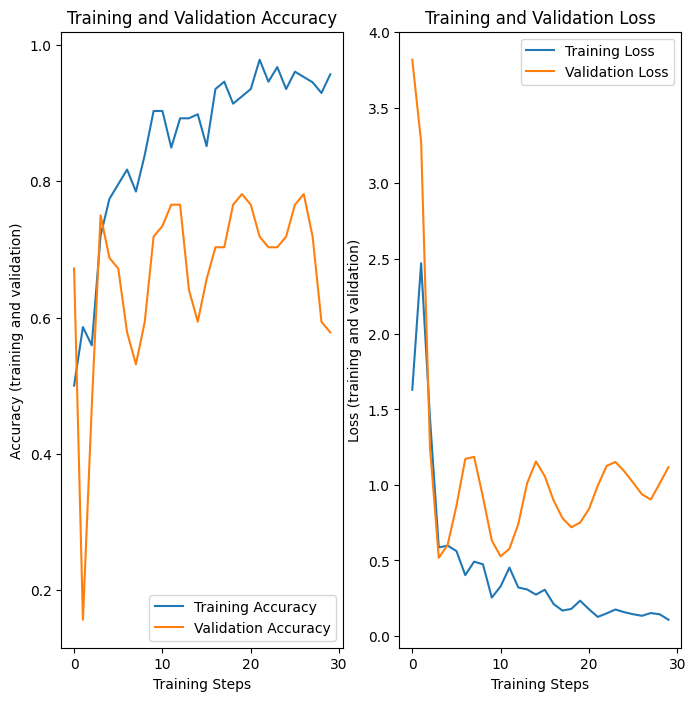

In [17]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

### Random test


In [18]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: brownspot, file: brownspot\brownspot_rotated_001.jpg
1/1 [==============================] - 1s 834ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.734577
Remedies:
Crop Rotation
Use of copper-based bactericides
Use of resistant varieties


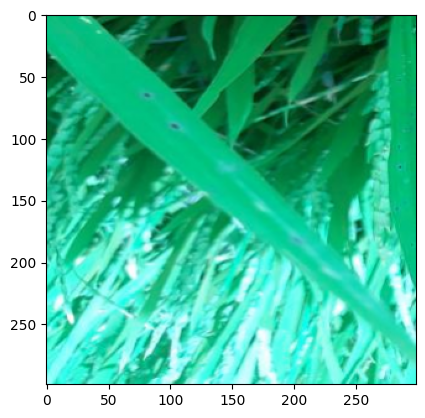

<Figure size 640x480 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight\blight_rotated_011.JPG
1/1 [==============================] - 0s 84ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.556288
Remedies:
Crop Rotation
Use of copper-based bactericides
Use of resistant varieties


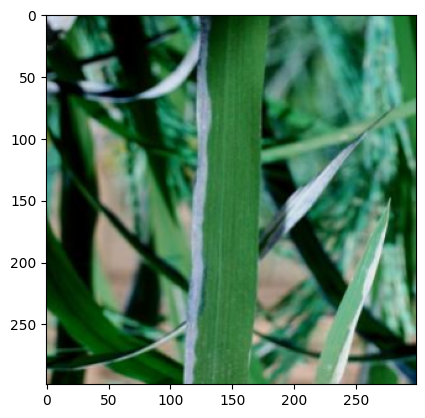

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight\blight_rotated_007.jpg
1/1 [==============================] - 0s 88ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.907914
Remedies:
Crop Rotation
Use of copper-based bactericides
Use of resistant varieties


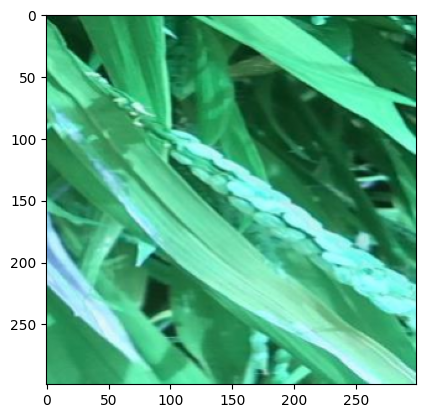

<Figure size 640x480 with 0 Axes>

SOURCE: class: brownspot, file: brownspot\brownspot_rotated_015.jpg
1/1 [==============================] - 0s 72ms/step
PREDICTED: class: brownspot, confidence: 0.929221
Remedies:
Fungicides
Crop rotation
Resistant varieties


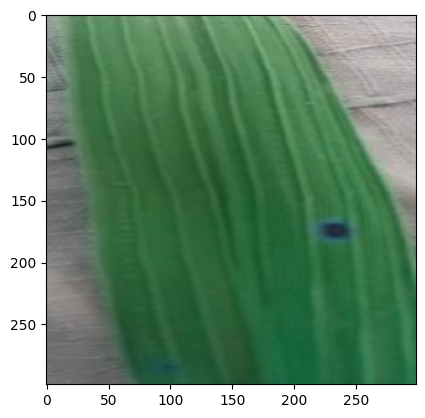

<Figure size 640x480 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight\blight_rotated_018.png
1/1 [==============================] - 0s 86ms/step
PREDICTED: class: blast, confidence: 0.758377
Remedies:
Crop Rotation
Use Fungicides
Biological Control


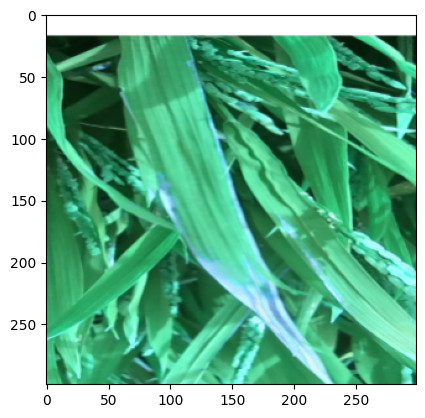

<Figure size 640x480 with 0 Axes>

In [19]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    if list(prediction.keys())[0]=="blast":
        print("Remedies:")
        print("Crop Rotation")
        print("Use Fungicides")
        print("Biological Control")
    elif list(prediction.keys())[0]=="Bacterial_leaf_blight":
        print("Remedies:")
        print("Crop Rotation")
        print("Use of copper-based bactericides")
        print("Use of resistant varieties")
    else:
        print("Remedies:")
        print("Fungicides")
        print("Crop rotation")
        print("Resistant varieties")
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()